In [1]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

HELLOOO 

In [2]:
sns.set(style='darkgrid', context='talk', palette='Dark2')

import praw

reddit = praw.Reddit(client_id='IKnXnWxiUuXhKA',
                     client_secret='wvvyNqFcSHiTLOgfTGcI_FIsaYIyew',
                     user_agent='tm_quant')

headlines = set()

for submission in reddit.subreddit('worldnews').top("day",limit=1):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

s = list(headlines)
new=s
new1=s

for i in range(0,len(s)):
    txt=s[i]
    s[i]=s[i].replace('%','percent')




from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


for i in range(0,len(s)):
    text = s[i]
    text_tokens = word_tokenize(text)

    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    new[i]=' '.join(tokens_without_sw)

import nltk
nltk.download('averaged_perceptron_tagger')
for i in range(0,len(s)):   
    sentence = new[i]
    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'JJ' and tag != 'JJR' and tag != 'JJS' and tag != 'RB' and tag != 'RBR' and tag != 'RBS']
    new1[i]=' '.join(edited_sentence)

import nltk
from pycorenlp import *
import collections

l = [None] * (len(headlines))

for i in range(0,len(headlines)):
    nlp=StanfordCoreNLP('http://localhost:9000/')
    x=new1[i]
    output = nlp.annotate(x, properties={"annotators":"tokenize,ssplit,pos,depparse,natlog,openie","triple.strict":"true",
                                     "outputFormat": "json",
                                        "openie.max_entailments_per_clause":"1"})
    
    result = [output["sentences"][0]["openie"] for item in output]
    if len(result[0])>0:
        z=len(result[0])
        relationSent=result[0][z-1]['relation'],result[0][z-1]['subject'],result[0][z-1]['object']
        l[i]=list(relationSent)
    else:
        l[i]=[None,None,None]
        
df = pd.DataFrame(l, columns =['P', 'S', 'O'], dtype = float)


df1 = df.replace(to_replace='None', value=np.nan).dropna()
df1.shape[0]/df.shape[0]

triples=df1.values

1


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tristanmantle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tristanmantle/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import urllib.parse

urls=[]

for z in range(0,len(new1)):
    try:
        ## initial consts
        BASE_URL = 'http://api.dbpedia-spotlight.org/en/annotate?text={text}&confidence={confidence}&support={support}'
        TEXT = new1[z]
        CONFIDENCE = '0.9'
        SUPPORT = '10'
        REQUEST = BASE_URL.format(
            text=urllib.parse.quote_plus(TEXT), 
            confidence=CONFIDENCE, 
            support=SUPPORT
        )
        HEADERS = {'Accept': 'application/json'}
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        all_urls = []

        r = requests.get(url=REQUEST, headers=HEADERS)
        response = r.json()
        resources = response['Resources']
        for res in resources:
            all_urls.append(res['@URI'])
        
        urls = all_urls + urls

    except:
        
        pass # doing nothing on exception
    
    
    


In [4]:
for j in range(0,len(headlines)):
    columns = ['S','P', 'O']
    data = []
    whole_df= pd.DataFrame(data,columns=columns)
    for i in range(0,len(urls)):
                
                line = 'DESCRIBE '
                output_line=line +'<' + urls[i] + '>'



                sparql = SPARQLWrapper("http://dbpedia.org/sparql")

                q="""

                    {}

                """.format(output_line)

                sparql.setQuery(q)



                sparql.setReturnFormat(JSON)
                results = sparql.query().convert()
                
                

                s_l = [None] * (len(results['results']['bindings']))
                p_l = [None] * (len(results['results']['bindings']))
                o_l = [None] * (len(results['results']['bindings']))
                for i in range(1,(len(results['results']['bindings']))):

                    s_l[i]=results['results']['bindings'][i]['s']['value']
                    p_l[i]=results['results']['bindings'][i]['p']['value']
                    o_l[i]=results['results']['bindings'][i]['o']['value']

                extra_df = pd.DataFrame(list(zip(s_l, p_l,o_l)),
                               columns =['S', 'P','O'])
                extra_df=extra_df.iloc[1:]
                
                

                extra_df = extra_df[extra_df.P != 'http://dbpedia.org/ontology/wikiPageWikiLink']
                extra_df = extra_df[extra_df.P != 'http://dbpedia.org/ontology/wikiPageExternalLink']
                extra_df = extra_df[extra_df.P != 'http://dbpedia.org/ontology/wikiPageLength']
                extra_df = extra_df[extra_df.P != 'http://dbpedia.org/ontology/wikiPageRedirects']
                extra_df = extra_df[extra_df.P != 'http://dbpedia.org/property/wikiPageUsesTemplate']

                extra_df['O'] = extra_df['O'].astype(str)
                extra_df=extra_df[extra_df['S'].str.contains("http://dbpedia.org/",na=False)]
                extra_df=extra_df[extra_df['P'].str.contains("http://dbpedia.org/",na=False)]
                extra_df=extra_df[extra_df['O'].str.contains("http://dbpedia.org/",na=False)]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/country"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/country"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/birthPlace"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/birthPlace"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/nationality"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/subdivisionName"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/deathPlace"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/location"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/location"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/deathPlace"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/stateOfOrigin"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/residence"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/locationCountry"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/regionServed"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/nationality"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/origin"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/spokenIn"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/hometown"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/states"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/citizenship"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/citizenship"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/populationPlace"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/locatedInArea"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/headquarter"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/residence"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/origin"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/city"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/city"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/ontology/president"]
                
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/president"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/hqLocationCountry"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/venue"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/nationalOrigin"]
                extra_df=extra_df.loc[extra_df['P'] != "http://dbpedia.org/property/stadium"]
                
               
        
                
                
                

                frames=[whole_df,extra_df]

                whole_df=pd.concat(frames)

In [5]:
#test=whole_df.groupby('P').count()
#test.sort_values(by=['O'])

In [6]:
final_df=pd.concat([df1, whole_df], sort=False)
final_df

,P,S,O


In [7]:
import networkx as nx
graph_df=final_df[0:2]

In [8]:
source = graph_df['S'].tolist()
target = graph_df['O'].tolist()
edge = graph_df['P'].tolist()
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})

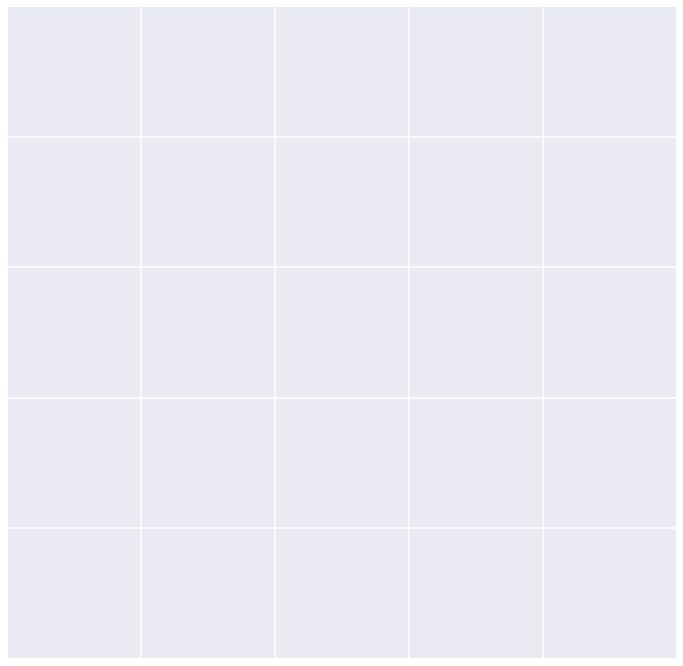

In [9]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos=pos)
plt.show()

In [ ]:
import numpy as np
from ampligraph.latent_features import TransE
triple=whole_df.values
model = TransE(batches_count=1, seed=555, epochs=20, k=10, loss='pairwise',loss_params={'margin':5})
X = triple
model.fit(X)

model.predict(X)